<a href="https://colab.research.google.com/github/callistacim/predict-bankrupt/blob/main/rev_tab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [8]:
df = pd.read_excel("project_ds.xlsx")
df

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev
0,2023-12-01,355401.0,329764,321474.0,651238.0,6104.0,356143,3.235842e+09,3253848075.834732
1,2023-12-02,328939.0,336808,377766.0,714574.0,4204.0,328753,3.504525e+09,3524025378.305361
2,2023-12-03,205178.0,49381,13179.0,62560.0,2947.0,216785,2.367166e+08,238033825.788049
3,2023-12-04,545267.0,600819,435942.0,1036761.0,5838.0,538934,4.356612e+09,4380854617.289699
4,2023-12-05,404052.0,440086,422757.0,862843.0,4743.0,404230,3.755460e+09,3776357370.557209
...,...,...,...,...,...,...,...,...,...
372,2024-12-07,369619.0,391225,452902.0,844127.0,5999.0,370221,5.564260e+09,0
373,2024-12-08,246511.0,62398,40372.0,102770.0,4224.0,253987,6.719560e+08,0
374,2024-12-09,594063.0,680102,543213.0,1223315.0,7804.0,592866,6.890170e+09,0
375,2024-12-10,468941.0,492933,463592.0,956525.0,5454.0,470406,5.207721e+09,0


check null value

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tanggal                377 non-null    datetime64[ns]
 1   total_order            375 non-null    float64       
 2   total_pickup           377 non-null    int64         
 3   total_delivery         375 non-null    float64       
 4   total_pickup_delivery  375 non-null    float64       
 5   total_cancel           375 non-null    float64       
 6   total_bookings         377 non-null    int64         
 7   total_revenue          377 non-null    float64       
 8   PnL_rev                377 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 26.6+ KB


In [10]:
print(df.isnull().sum())

tanggal                  0
total_order              2
total_pickup             0
total_delivery           2
total_pickup_delivery    2
total_cancel             2
total_bookings           0
total_revenue            0
PnL_rev                  0
dtype: int64


In [13]:
df['total_order'] = df['total_order'].fillna(0).astype(int)
df['total_delivery'] = df['total_delivery'].fillna(0).astype(int)
df['total_pickup_delivery'] = df['total_pickup_delivery'].fillna(0).astype(int)
df['total_cancel'] = df['total_cancel'].fillna(0).astype(int)
df['total_revenue'] = df['total_revenue'].fillna(0).astype(int)
df['PnL_rev'] = pd.to_numeric(df['PnL_rev'].str.replace(' ', ''), errors='coerce').fillna(0).astype(int)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tanggal                377 non-null    datetime64[ns]
 1   total_order            377 non-null    int64         
 2   total_pickup           377 non-null    int64         
 3   total_delivery         377 non-null    int64         
 4   total_pickup_delivery  377 non-null    int64         
 5   total_cancel           377 non-null    int64         
 6   total_bookings         377 non-null    int64         
 7   total_revenue          377 non-null    int64         
 8   PnL_rev                377 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 26.6 KB


In [15]:
df.dropna()

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,0
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,0
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,0
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,0
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,0
...,...,...,...,...,...,...,...,...,...
372,2024-12-07,369619,391225,452902,844127,5999,370221,5564260039,0
373,2024-12-08,246511,62398,40372,102770,4224,253987,671956037,0
374,2024-12-09,594063,680102,543213,1223315,7804,592866,6890170467,0
375,2024-12-10,468941,492933,463592,956525,5454,470406,5207720658,0


add col holiday

In [16]:
pip install holidays


In [17]:
import holidays

# Get Indonesian holidays for a specific year (e.g., 2024)
indonesia_holidays = holidays.Indonesia(years=2024)

# Print all holidays
for date, name in sorted(indonesia_holidays.items()):
    print(date, name)


2024-01-01 New Year's Day
2024-02-08 Isra' and Mi'raj
2024-02-10 Lunar New Year
2024-02-14 General Election Day
2024-03-11 Day of Silence
2024-03-29 Good Friday
2024-03-31 Easter Sunday
2024-04-10 Eid al-Fitr
2024-04-11 Eid al-Fitr Second Day
2024-05-01 International Labor Day
2024-05-09 Ascension Day
2024-05-23 Vesak Day
2024-06-01 Pancasila Day
2024-06-17 Eid al-Adha
2024-07-07 Islamic New Year
2024-08-17 Independence Day
2024-09-16 Prophet's Birthday
2024-11-27 Local Election Day
2024-12-25 Christmas Day


In [18]:
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [19]:
import holidays
import datetime # Import the datetime module

# Get Indonesian holidays for a specific year (e.g., 2024)
indonesia_holidays = holidays.Indonesia(years=2024)

# Print all holidays
for date, name in sorted(indonesia_holidays.items()):
    print(date, name)

# Example: Check if a given date is a holiday
def is_holiday(date):
    for holiday in indonesia_holidays:
        if holiday[0] == date:
            return holiday[1]
    return None

# Function to check if a date is a holiday
def check (date):
    # Convert the pandas Timestamp to a datetime.date object
    date_object = date.to_pydatetime().date()
    return "Holiday" if date_object in indonesia_holidays else "Not Holiday"

# Apply the function to create the 'Holiday' column
df['Holiday'] = df['tanggal'].apply(check)

# Display the DataFrame
print(df)

2024-01-01 New Year's Day
2024-02-08 Isra' and Mi'raj
2024-02-10 Lunar New Year
2024-02-14 General Election Day
2024-03-11 Day of Silence
2024-03-29 Good Friday
2024-03-31 Easter Sunday
2024-04-10 Eid al-Fitr
2024-04-11 Eid al-Fitr Second Day
2024-05-01 International Labor Day
2024-05-09 Ascension Day
2024-05-23 Vesak Day
2024-06-01 Pancasila Day
2024-06-17 Eid al-Adha
2024-07-07 Islamic New Year
2024-08-17 Independence Day
2024-09-16 Prophet's Birthday
2024-11-27 Local Election Day
2024-12-25 Christmas Day
       tanggal  total_order  total_pickup  total_delivery  \
0   2023-12-01       355401        329764          321474   
1   2023-12-02       328939        336808          377766   
2   2023-12-03       205178         49381           13179   
3   2023-12-04       545267        600819          435942   
4   2023-12-05       404052        440086          422757   
..         ...          ...           ...             ...   
372 2024-12-07       369619        391225          452902   

add col twin date

In [23]:
import pandas as pd
import datetime

twin_dates = [
    datetime.date(2024, 1, 1),  # January 1st
    datetime.date(2024, 2, 2),  # February 2nd
    datetime.date(2024, 3, 3),  # March 3rd
    datetime.date(2024, 4, 4),  # April 4th
    datetime.date(2024, 5, 5),  # May 5th
    datetime.date(2024, 6, 6),  # June 6th
    datetime.date(2024, 7, 7),  # July 7th
    datetime.date(2024, 8, 8),  # August 8th
    datetime.date(2024, 9, 9),  # September 9th
    datetime.date(2024, 10, 10), # October 10th
    datetime.date(2024, 11, 11),  # November 11th
    datetime.date(2024, 12, 12)  # Dec 12th
]

# Convert 'tanggal' column to datetime format
df['tanggal'] = pd.to_datetime(df['tanggal']).dt.date

# Function to check if the date is a twin date (month == day)
def check_twin_date(date):
    # Check if the date is in the list of twin dates
    if date in twin_dates:
        return 'Yes'  # Twin date found
    return 'No'  # Not a twin date

# Apply the function to create the 'Twin Date' column
df['Twin Date'] = df['tanggal'].apply(check_twin_date)

# Display the DataFrame
print(df)


        tanggal  total_order  total_pickup  total_delivery  \
0    2023-12-01       355401        329764          321474   
1    2023-12-02       328939        336808          377766   
2    2023-12-03       205178         49381           13179   
3    2023-12-04       545267        600819          435942   
4    2023-12-05       404052        440086          422757   
..          ...          ...           ...             ...   
372  2024-12-07       369619        391225          452902   
373  2024-12-08       246511         62398           40372   
374  2024-12-09       594063        680102          543213   
375  2024-12-10       468941        492933          463592   
376  2024-12-11       517088        451696          507910   

     total_pickup_delivery  total_cancel  total_bookings  total_revenue  \
0                   651238          6104          356143     3235842325   
1                   714574          4204          328753     3504524553   
2                    62560    

In [24]:
df.head(10)

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,0,Not Holiday,No
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,0,Not Holiday,No
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,0,Not Holiday,No
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,0,Not Holiday,No
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,0,Not Holiday,No
5,2023-12-06,383024,396109,451579,847688,4713,383961,4015738399,0,Not Holiday,No
6,2023-12-07,361369,367295,447253,814548,5272,361513,4042204728,0,Not Holiday,No
7,2023-12-08,340207,343237,388127,731364,6458,340508,3767217826,0,Not Holiday,No
8,2023-12-09,290664,313216,326823,640039,4534,290816,3308727097,0,Not Holiday,No
9,2023-12-10,180824,40263,12862,53125,3070,191449,268951814,0,Not Holiday,No


In [25]:
def check(tanggal):
    # Check if the date is a holiday or a Sunday (weekday() == 6)
    is_holiday = tanggal in indonesia_holidays # Removed .date()
    is_sunday = tanggal.weekday() == 6  # 6 represents Sunday

    # Return "Holiday" if either condition is True
    return "Holiday" if is_holiday or is_sunday else "Not Holiday"

# Apply the function to create the 'Holiday' column
df['Holiday'] = df['tanggal'].apply(check)

In [26]:
df['Holiday'].value_counts()


,count
Holiday,
Not Holiday,306
Holiday,71


In [27]:
print(df['Holiday'].head(10))    # 6 is Sunday = Holiday

0    Not Holiday
1    Not Holiday
2        Holiday
3    Not Holiday
4    Not Holiday
5    Not Holiday
6    Not Holiday
7    Not Holiday
8    Not Holiday
9        Holiday
Name: Holiday, dtype: object


In [28]:
df.head(10)

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,0,Not Holiday,No
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,0,Not Holiday,No
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,0,Holiday,No
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,0,Not Holiday,No
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,0,Not Holiday,No
5,2023-12-06,383024,396109,451579,847688,4713,383961,4015738399,0,Not Holiday,No
6,2023-12-07,361369,367295,447253,814548,5272,361513,4042204728,0,Not Holiday,No
7,2023-12-08,340207,343237,388127,731364,6458,340508,3767217826,0,Not Holiday,No
8,2023-12-09,290664,313216,326823,640039,4534,290816,3308727097,0,Not Holiday,No
9,2023-12-10,180824,40263,12862,53125,3070,191449,268951814,0,Holiday,No


In [ ]:
# for col in df.columns:
#     if df[col].dtype in ['int64', 'float64']:
#         df[col] = df[col].apply(lambda x: "{:.}".format(x))  # For commas as thousand separator

## Encode

In [29]:
df['Holiday'] = df['Holiday'].map({'Holiday': 1, 'Not Holiday': 0})


In [30]:
df['Twin Date'] = df['Twin Date'].map({'Yes': 1, 'No': 0})


In [31]:
# check dtype
df.dtypes

,0
tanggal,object
total_order,int64
total_pickup,int64
total_delivery,int64
total_pickup_delivery,int64
total_cancel,int64
total_bookings,int64
total_revenue,int64
PnL_rev,int64
Holiday,int64


# CORRELATION

In [35]:
drop_col_corr = ['PnL_rev','tanggal']
correlation_matrix = df.drop(columns=drop_col_corr).corr()

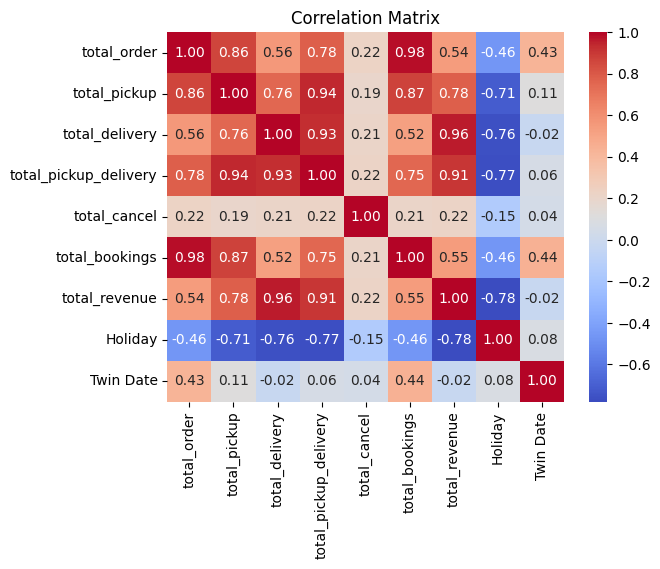

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [43]:
# highest to lowest corr for 'total_rev'
sorted_corr = correlation_matrix['total_revenue'].sort_values(ascending=False)
sorted_corr

,total_revenue
total_revenue,1.000000
total_delivery,0.960693
total_pickup_delivery,0.906527
total_pickup,0.778319
total_bookings,0.545380
total_order,0.542778
total_cancel,0.218601
Twin Date,-0.024557
Holiday,-0.779648


## Corr Delivery

In [42]:
sorted_corr = correlation_matrix['total_delivery'].sort_values(ascending=False)
sorted_corr

,total_delivery
total_delivery,1.000000
total_revenue,0.960693
total_pickup_delivery,0.929215
total_pickup,0.755900
total_order,0.556502
total_bookings,0.522211
total_cancel,0.209696
Twin Date,-0.022516
Holiday,-0.759516


## Corr Bookings

In [40]:
sorted_corr = correlation_matrix['total_bookings'].sort_values(ascending=False)
sorted_corr

,total_bookings
total_bookings,1.000000
total_order,0.980819
total_pickup,0.869567
total_pickup_delivery,0.751819
total_revenue,0.545380
total_delivery,0.522211
Twin Date,0.442092
total_cancel,0.213719
Holiday,-0.461559


There are only a limited number of twin dates in a full year. DS doesn't hv enuf data points for twin dates, it could make it difficult to accurately capture the correlation-> lower correlation value than expected.

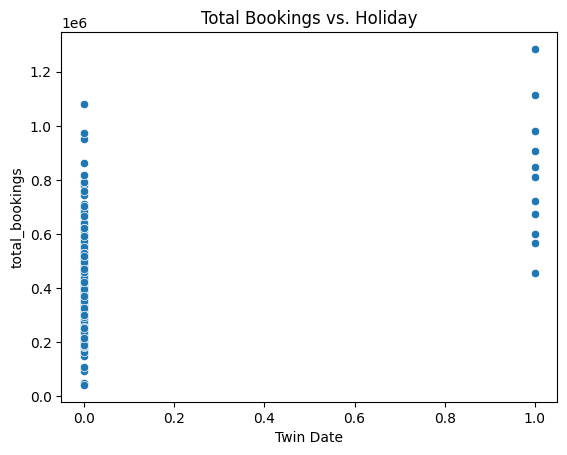

In [46]:
# Scatter plot of 'total_bookings' vs. 'Twin Date'
sns.scatterplot(x='Twin Date', y='total_bookings', data=df)
plt.title('Total Bookings vs. Holiday')
plt.show()

In [ ]:
for i in range(1,12)
  col_name = 'day'

In [47]:
df

,tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date
0,2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,0,0,0
1,2023-12-02,328939,336808,377766,714574,4204,328753,3504524553,0,0,0
2,2023-12-03,205178,49381,13179,62560,2947,216785,236716623,0,1,0
3,2023-12-04,545267,600819,435942,1036761,5838,538934,4356612374,0,0,0
4,2023-12-05,404052,440086,422757,862843,4743,404230,3755460221,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
372,2024-12-07,369619,391225,452902,844127,5999,370221,5564260039,0,0,0
373,2024-12-08,246511,62398,40372,102770,4224,253987,671956037,0,1,0
374,2024-12-09,594063,680102,543213,1223315,7804,592866,6890170467,0,0,0
375,2024-12-10,468941,492933,463592,956525,5454,470406,5207720658,0,0,0


In [51]:
df.to_excel('cleaned_ds.xlsx')

In [52]:
df.value_counts()

,,,,,,,,,,,count
tanggal,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,total_revenue,PnL_rev,Holiday,Twin Date,
2023-12-01,355401,329764,321474,651238,6104,356143,3235842325,0,0,0,1
2024-08-05,599098,693706,594492,1288198,9132,597572,6527519137,0,0,0,1
2024-08-14,401203,405837,491786,897623,5175,401980,5252214387,0,0,0,1
2024-08-13,411321,452997,475937,928934,5323,411073,5251170003,0,0,0,1
2024-08-12,554824,640492,530840,1171332,8132,553066,6411605733,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-03,539153,598258,539646,1137904,12110,540262,5632789361,0,0,0,1
2024-04-02,682422,742877,488809,1231686,8925,678229,5717407322,0,0,0,1
2024-04-01,746555,752015,517970,1269985,8983,744075,6071356882,0,0,0,1


In [53]:
# Day of the week
# Ensure 'tanggal' column is in datetime format before using .dt accessor
df['tanggal'] = pd.to_datetime(df['tanggal'])
df['day_of_week'] = df['tanggal'].dt.dayofweek

# Rolling average for the past 7 days
df['rolling_avg_7'] = df['total_revenue'].rolling(window=7).mean()

# Lag feature for previous day's sales
df['prev_day_sales'] = df['total_revenue'].shift(1)

# Binary indicator for weekend
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [190]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Define features and target
features = ['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend', 'rolling_avg_7', 'prev_day_sales']
target = 'total_revenue'

# Prepare data
X = df[features]
y = df[target]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the model
XGBmodel = XGBRegressor(n_estimators=350, learning_rate=0.05)

# Train the model
XGBmodel.fit(X_train, y_train)

# Evaluate the model
y_pred = XGBmodel.predict(X_test)


In [191]:
y_pred

array([5.4797594e+09, 5.1916232e+09, 3.7508208e+08, 6.1558431e+09,
       4.4720435e+09, 5.2091397e+09, 5.7021834e+09, 5.0995881e+09,
       4.5922831e+09, 3.6896989e+08, 6.1497723e+09, 4.9751480e+09,
       5.3772856e+09, 5.7340708e+09, 5.6474450e+09, 6.5914030e+09,
       3.0892111e+09, 7.1635164e+09, 5.5926804e+09, 5.6612188e+09,
       5.7070935e+09, 4.9164247e+09, 4.6640707e+09, 6.6139814e+08,
       6.2853289e+09, 4.6573752e+09, 5.0170650e+09, 5.0881019e+09,
       4.5713710e+09, 4.4904781e+09, 3.6052938e+08, 6.4054062e+09,
       4.8301276e+09, 5.0584591e+09, 5.1188557e+09, 4.7965025e+09,
       4.6409498e+09, 3.5034346e+08, 6.1644017e+09, 4.6553293e+09,
       5.3633618e+09, 5.4478612e+09, 5.1696353e+09, 4.7467832e+09,
       3.8028509e+08, 6.3423570e+09, 5.2045460e+09, 6.2708316e+09,
       7.2314967e+09, 6.7225139e+09, 6.7480279e+09, 3.1027113e+09,
       5.3488763e+09, 4.5040968e+09, 5.1580861e+09, 4.9505731e+09,
       4.3799091e+09, 4.4668237e+09, 3.3308563e+08, 5.8324741e

In [192]:
import pandas as pd

# Get feature importance
feature_importance = XGBmodel.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance report
print(importance_df)


                  Feature  Importance
1            total_pickup    0.842027
2          total_delivery    0.114342
3   total_pickup_delivery    0.022204
9           rolling_avg_7    0.010095
10         prev_day_sales    0.003596
4            total_cancel    0.003302
0             total_order    0.002712
5          total_bookings    0.000923
6                 Holiday    0.000427
8              is_weekend    0.000363
7               Twin Date    0.000010


In [193]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 218318500.5
Root Mean Squared Error (RMSE): 289934769.7186988


In [164]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9756234288215637


In [195]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define features and target
features = ['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend', 'rolling_avg_7', 'prev_day_sales']
target = 'total_revenue'

# Prepare data
X = df[features]
y = df[target]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor())
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} R²: {r2}')


# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Linear Regression R²: 0.9810458539251724
Random Forest R²: 0.9784413060895085
Mean Absolute Error (MAE): 194508991.0038158
Root Mean Squared Error (RMSE): 272662207.0448601


# prophet

In [166]:
!pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running set

In [167]:
!apt-get update
!apt-get install build-essential

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,516 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,543 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd

In [168]:
!apt-get install libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
libgomp1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [169]:
!CC=gcc CXX=g++ pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 k

In [170]:
!pip install ephem

  Using cached ephem-4.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
Using cached ephem-4.1.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)


In [171]:
!pip install --no-cache-dir fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 158.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 159.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 188.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 111.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
  Created wheel for pymeeus: filename=PyMee

In [172]:
!pip install httpstan

  Using cached httpstan-4.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached marshmallow-3.23.1-py3-none-any.whl.metadata (7.5 kB)
  Using cached webargs-8.6.0-py3-none-any.whl.metadata (6.5 kB)
Using cached httpstan-4.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.5 MB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached marshmallow-3.23.1-py3-none-any.whl (49 kB)
Using cached webargs-8.6.0-py3-none-any.whl (31 kB)


In [173]:
!pip install --no-cache-dir prophet

In [174]:
!pip install pystan==2.19.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 44.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to build pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [175]:
from prophet import Prophet

# Instantiate Prophet with cmdstanpy backend
model = Prophet(stan_backend='CMDSTANPY')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqqkibb_/x1maaw2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqqkibb_/_jpxzqr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51207', 'data', 'file=/tmp/tmpyqqkibb_/x1maaw2b.json', 'init=/tmp/tmpyqqkibb_/_jpxzqr0.json', 'output', 'file=/tmp/tmpyqqkibb_/prophet_model9ohpijqx/prophet_model-20241216192456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


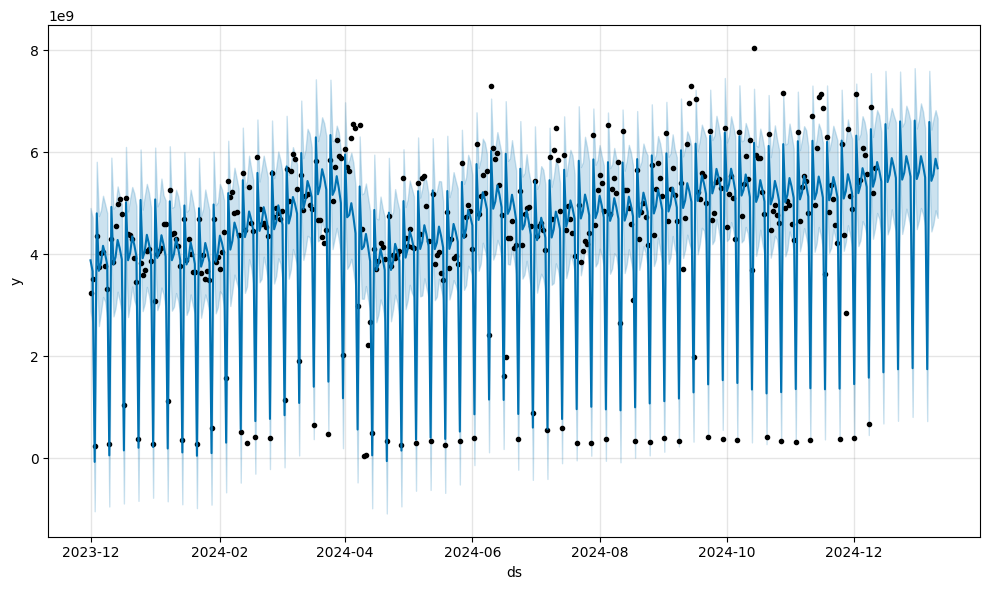

In [176]:
# Prepare data for Prophet (column names must be 'ds' for dates and 'y' for target values)
df_prophet = df[['tanggal', 'total_revenue']].reset_index()  # Include 'tanggal' in the selection
df_prophet.rename(columns={'tanggal': 'ds', 'total_revenue': 'y'}, inplace=True)

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=30)  # Forecast for the next 30 days
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

In [177]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example: Actual data vs predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared: {r2}")


Mean Absolute Error (MAE): 218318500.5
Root Mean Squared Error (RMSE): 289934769.7186988
R-Squared: 0.9756234288215637


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


* ds: future dates (including past
and future)
* yhat: predicted value of target variable (total revenue in this case)
* yhat_lower and yhat_upper: The lower and upper bounds of the prediction, showing the uncertainty range.

In [178]:
# Format the numbers for better readability
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)

# View the last few predicted values with improved readability
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds              yhat        yhat_lower        yhat_upper
402 2025-01-06  6,592,367,528.22  5,586,250,080.64  7,596,197,297.23
403 2025-01-07  5,437,975,512.30  4,446,534,364.88  6,443,216,937.70
404 2025-01-08  5,560,479,724.56  4,595,102,781.83  6,650,299,092.43
405 2025-01-09  5,871,872,243.55  4,861,170,742.45  6,824,820,339.92
406 2025-01-10  5,684,062,389.65  4,711,543,036.72  6,664,177,206.83


<ipython-input-178-6764d3cfa22d>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


In [179]:
print(forecast.columns)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


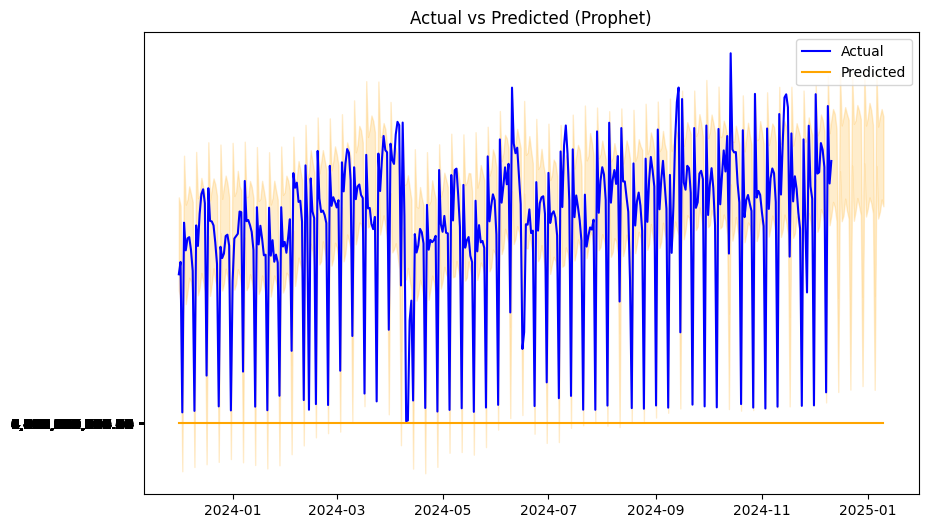

In [180]:
# Merge the forecast with actual data
actuals = df[['tanggal', 'total_revenue']].rename(columns={'tanggal': 'ds', 'total_revenue': 'y'}) # Change 'ds' to 'tanggal'
# Include 'yhat_lower' and 'yhat_upper' in the merge
comparison = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], actuals, on='ds', how='left')

# Convert 'yhat_lower' and 'yhat_upper' back to numeric if needed
comparison['yhat_lower'] = pd.to_numeric(comparison['yhat_lower'].str.replace(',', ''))
comparison['yhat_upper'] = pd.to_numeric(comparison['yhat_upper'].str.replace(',', ''))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual', color='blue')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='orange')
plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='orange', alpha=0.2)
plt.legend()
plt.title('Actual vs Predicted (Prophet)')
plt.show()

In [183]:
forecast.to_csv('forecast.csv', index=False)

In [184]:
from prophet import Prophet
import pandas as pd

# Assuming indonesia_holidays is your holidays.Indonesia object
holidays_df = pd.DataFrame(list(indonesia_holidays.items()), columns=['ds', 'holiday'])

# Instantiate Prophet with cmdstanpy backend and the holidays DataFrame
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays_df  # Pass the DataFrame to holidays argument
    #stan_backend='CMDSTANPY'  # Uncomment if CMDSTANPY backend is desired
)

In [186]:
# test data test
X_test

,total_order,total_pickup,total_delivery,total_pickup_delivery,total_cancel,total_bookings,Holiday,Twin Date,is_weekend,rolling_avg_7,prev_day_sales
301,416391,428702,517654,946356,5411,415795,0,0,0,4.600534e+09,5.422425e+09
302,358916,376000,491457,867457,5284,358966,0,0,1,4.643086e+09,5.482791e+09
303,228054,75511,19015,94526,3949,237585,1,0,1,4.637672e+09,5.301814e+09
304,532467,630254,544391,1174645,7282,529754,0,0,0,4.645423e+09,3.664629e+08
305,472034,461468,424736,886204,4288,478698,0,0,0,4.623128e+09,6.466090e+09
...,...,...,...,...,...,...,...,...,...,...,...
372,369619,391225,452902,844127,5999,370221,0,0,1,5.142491e+09,5.940060e+09
373,246511,62398,40372,102770,4224,253987,1,0,1,5.182959e+09,5.564260e+09
374,594063,680102,543213,1223315,7804,592866,0,0,0,5.146285e+09,6.719560e+08
375,468941,492933,463592,956525,5454,470406,0,0,0,5.115599e+09,6.890170e+09


In [189]:
print(features)

['total_order', 'total_pickup', 'total_delivery', 'total_pickup_delivery', 'total_cancel', 'total_bookings', 'Holiday', 'Twin Date', 'is_weekend', 'rolling_avg_7', 'prev_day_sales']


In [188]:
X_test.to_excel('X_test.xlsx')

In [196]:
# Manually input the test data @ row 376
tes_data = pd.DataFrame({
    'total_order': [517088],
    'total_pickup': [451696],
    'total_delivery': [507910],
    'total_pickup_delivery': [959606],
    'total_cancel': [105275],
    'total_bookings': [518884],
    'Holiday': [0],  # This might be binary: 0 for non-holiday, 1 for holiday
    'Twin Date': [0],  # 0 or 1 for twin date feature
    'is_weekend': [0],  # 0 for weekdays, 1 for weekends
    'rolling_avg_7': [5150701028],
    'prev_day_sales': [5207720658]
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)


Prediction for single data point: [5.505365e+09]


In [ ]:
# Manually input the test data @ row 376
tes_data = pd.DataFrame({
    'total_order': [517088],
    'total_pickup': [451696],
    'total_delivery': [507910],
    'total_pickup_delivery': [959606],
    'total_cancel': [105275],
    'total_bookings': [518884],
    'Holiday': [0],  # This might be binary: 0 for non-holiday, 1 for holiday
    'Twin Date': [0],  # 0 or 1 for twin date feature
    'is_weekend': [0],  # 0 for weekdays, 1 for weekends
    'rolling_avg_7': [5150701028],
    'prev_day_sales': [5207720658]
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)


In [199]:
test_data = pd.DataFrame({
    'total_order': [422.898],
    'total_pickup': [435.715],
    'total_delivery': [521.283],
    'total_pickup_delivery': [956.998],
    'total_cancel': [7.455],
    'total_bookings': [423.889],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [5044211392],  # Corrected to avoid periods in the number
    'prev_day_sales': [6084538977]  # Corrected to avoid periods in the number
})
# Get the prediction for the single data point
prediction = XGBmodel.predict(tes_data)
print("Prediction for single data point:", prediction)

# For float numbers
number = 5.505365e+09
formatted_number = f"{number:,.0f}"
print(formatted_number)



Prediction for single data point: [5.505365e+09]


In [202]:
test_data = pd.DataFrame({
    'total_order': [416391],
    'total_pickup': [428702],
    'total_delivery': [517654],
    'total_pickup_delivery': [946356],
    'total_cancel': [5411],
    'total_bookings': [415795],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [4600533911],  # Corrected format (removed periods)
    'prev_day_sales': [5422425224]  # Corrected format (removed periods)
})

# Load or use your trained model
# Assuming you have already trained the model or loaded a saved one
model = XGBRegressor()  # Example, replace with actual model
# model.fit(X_train, y_train)  # If you haven't trained yet, use this line

# Make the prediction for the test data
prediction = XGBmodel.predict(test_data)
print("Prediction:", prediction)


Prediction: [5.4797594e+09]


In [204]:
result = 5.4797594e+09
formatted_result = "Prediction for single data point: {:,.0f}".format(result)
print(formatted_result)

Prediction for single data point: 5,479,759,400


In [205]:
test_data = pd.DataFrame({
    'total_order': [416391],
    'total_pickup': [425000],
    'total_delivery': [517654],
    'total_pickup_delivery': [946356],
    'total_cancel': [5000],
    'total_bookings': [415795],
    'Holiday': [0],  # Assuming no holiday (if missing, you can set it to 0 or another neutral value)
    'Twin Date': [0],  # Assuming no twin date (if missing, set it to 0)
    'is_weekend': [0],  # Assuming it's not a weekend (if missing, set it to 0)
    'rolling_avg_7': [4600533911],  # Corrected format (removed periods)
    'prev_day_sales': [5422425224]  # Corrected format (removed periods)
})

# Load or use your trained model
# Assuming you have already trained the model or loaded a saved one
model = XGBRegressor()  # Example, replace with actual model
# model.fit(X_train, y_train)  # If you haven't trained yet, use this line

# Make the prediction for the test data
prediction = XGBmodel.predict(test_data)
print("Prediction:", prediction)


Prediction: [5.4899205e+09]


In [209]:
# Assuming y_pred is your numpy array
y_pred_df = pd.DataFrame(y_pred, columns=['Predictions'])  # Create a DataFrame

# Now you can use to_excel:
y_pred_df.to_excel('y_pred.xlsx', index=False)  # Save to Excel, index=True to avoid row numbers